<a href="https://colab.research.google.com/github/kjprice/smu-capstone/blob/master/notebooks/ASL_Signs_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil, copy, ntpath, datetime, zipfile, json
import keras
from keras import models, layers, callbacks

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

Using TensorFlow backend.


#### Settings

In [2]:
IMAGE_SHAPE=(150, 150, 3)

LIMIT_BATCHES = 800
#LIMIT_BATCHES = 593
#LIMIT_BATCHES = None

NUM_EPOCHS = 10
BATCH_SIZE = 27

# PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = VGG16
#PRETRAIN_MODEL = VGG19
#PRETRAIN_MODEL = Xception
#PRETRAIN_MODEL = ResNet50
# PRETRAIN_MODEL = None

UNFREEZE_LAYERS=3

USE_PREPROCESSED_IMAGES = False

TEST_TRAIN_SPLIT = .95 # Train Size

#### Set Folders

In [3]:
def ensure_directory_exists(directory):
  try:
    return os.makedirs(directory)
  except:
    return None
 

In [4]:
DATA_DIRECTORY = os.path.join('..', 'data')

MODEL_TIMESTAMP = str(datetime.datetime.now()).replace(' ', '__')

SAVED_MODEL_DIR = os.path.join(DATA_DIRECTORY, 'models/asl_alphabet')
SAVED_CLASS_DIR = os.path.join(DATA_DIRECTORY, 'models/asl_alphabet_class_names')

In [5]:
#### Local FilePath Information

LOCAL_DATASET_DIR = os.path.join(DATA_DIRECTORY, 'fabricated', 'asl_alphabet')
TRAIN_DATASET_NAME = 'processed_asl_train'

LOCAL_TRAIN_DIR = os.path.join(LOCAL_DATASET_DIR, TRAIN_DATASET_NAME)


#### Download Data

In [6]:
LOCAL_DATASET_DIR

'../data/fabricated/asl_alphabet'

#### Extract Data

In [7]:
AVAILABLE_DATASETS = os.listdir(LOCAL_DATASET_DIR)
print(AVAILABLE_DATASETS)

['processed_ahe_grayscale_inverted_asl_test', 'processed_inverted_rgb_ahe_test', 'processed_rgb_ahe_test', 'processed_ahe_grayscale_asl_test', 'split_asl_alphabet_train', 'processed_original_test', 'processed_asl_train', 'split_asl_alphabet_test', 'processed_grayscale_test']


In [8]:
if not TRAIN_DATASET_NAME in AVAILABLE_DATASETS:
  raise Exception('we are expecting to see {} as one of the available datasets'.format(TRAIN_DATASET_NAME))
TEST_DATASET_NAMES = [dataset for dataset in AVAILABLE_DATASETS if dataset != TRAIN_DATASET_NAME and 'test' in dataset]
print('We have one training set and {} test sets'.format(len(TEST_DATASET_NAMES)))
LOCAL_TEST_DIRS = [os.path.join(LOCAL_DATASET_DIR, name) for name in TEST_DATASET_NAMES]

We have one training set and 7 test sets


#### Create Split training/test data

In [9]:
def get_sign_folders(from_folder):
  # https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
  folders = next(os.walk(from_folder))[1]
  return folders

In [10]:
# A, B, C, D, DELETE, etc
ASL_FOLDERS = get_sign_folders(LOCAL_TRAIN_DIR)
NUM_CLASSES = len(ASL_FOLDERS)

print('We have {} folders'.format(NUM_CLASSES))

We have 41 folders


#### Create Data Generators

In [11]:
def create_test_datagen(directory):
  test_datagen = ImageDataGenerator(rescale=1./255)
  return test_datagen.flow_from_directory(
         directory,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
  )

In [12]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [13]:
#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)

test_generators = [create_test_datagen(dir) for dir in LOCAL_TEST_DIRS]

Found 25026 images belonging to 41 classes.
Found 2762 images belonging to 41 classes.
Found 0 images belonging to 41 classes.
Found 0 images belonging to 41 classes.
Found 384 images belonging to 41 classes.
Found 384 images belonging to 41 classes.
Found 384 images belonging to 41 classes.
Found 384 images belonging to 41 classes.
Found 384 images belonging to 41 classes.


In [51]:
def save_generator_classes(gen=train_generator):
    label_map = (gen.class_indices)

    filename = os.path.join(SAVED_CLASS_DIR, '{}-data.json'.format(MODEL_TIMESTAMP))
    print('saving {}'.format(filename))
    with open(filename, 'w') as outfile:
        json.dump(label_map, outfile)

# Models

In [15]:
conv_base2 = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))

In [16]:
def freeze_layers(layers):
  num_layers = len(layers)
  num_layers_to_freeze = num_layers - UNFREEZE_LAYERS
  for i in range(0, num_layers_to_freeze):
    layers[i].trainable = False


In [17]:
def create_pretrained_model(BASE):   
    conv_base = BASE(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    print(conv_base.summary())
    
    freeze_layers(conv_base.layers)
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model
    
    

In [18]:
def create_blank_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    #Add a classfier on top of the convnet
    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    #compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model


In [19]:
if not PRETRAIN_MODEL:
    model = create_blank_model()
else:
    model = create_pretrained_model(PRETRAIN_MODEL)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [20]:
steps_per_epoch = None

if LIMIT_BATCHES is None:
  steps_per_epoch_train = len(train_generator)
  steps_per_epoch_val = len(validation_generator)
  steps_per_epoch_test = len(test_generators[0])
else:
  steps_per_epoch_train = LIMIT_BATCHES
  steps_per_epoch_val = (LIMIT_BATCHES / len(train_generator)) * len(validation_generator)
  steps_per_epoch_test = (LIMIT_BATCHES / len(train_generator)) * len(test_generators[0])

print('total batches {}'.format(len(train_generator)))
print('steps_per_epoch_train {}'.format(steps_per_epoch_train))
print('steps_per_epoch_test {}'.format(steps_per_epoch_test))
print('steps_per_epoch_val {}'.format(steps_per_epoch_val))


total batches 927
steps_per_epoch_train 800
steps_per_epoch_test 0.0
steps_per_epoch_val 88.88888888888889


In [21]:
weight_filename = "weights-improvement-" + MODEL_TIMESTAMP + "-{epoch:02d}-{val_acc:.2f}.hdf5"

saved_model_filepath = os.path.join(SAVED_MODEL_DIR, weight_filename)
callbacks_list = [callbacks.ModelCheckpoint(saved_model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]

history= model.fit_generator (
  train_generator,
  epochs = NUM_EPOCHS,
  steps_per_epoch=steps_per_epoch_train,
  validation_steps=steps_per_epoch_val,
  callbacks = callbacks_list,
  validation_data=validation_generator,
  verbose=1 \
)

Epoch 1/10
800/800 [==============================] - 2167s 3s/step - loss: 1.1957 - acc: 0.6552 - val_loss: 0.4758 - val_acc: 0.8410

Epoch 00001: val_acc improved from -inf to 0.84103, saving model to ../data/models/asl_alphabet/weights-improvement-2019-05-25__21:33:02.665517-01-0.84.hdf5
Epoch 2/10
800/800 [==============================] - 2131s 3s/step - loss: 0.3578 - acc: 0.8862 - val_loss: 0.2859 - val_acc: 0.9119

Epoch 00002: val_acc improved from 0.84103 to 0.91191, saving model to ../data/models/asl_alphabet/weights-improvement-2019-05-25__21:33:02.665517-02-0.91.hdf5
Epoch 3/10
800/800 [==============================] - 2132s 3s/step - loss: 0.2404 - acc: 0.9247 - val_loss: 0.1976 - val_acc: 0.9341

Epoch 00003: val_acc improved from 0.91191 to 0.93414, saving model to ../data/models/asl_alphabet/weights-improvement-2019-05-25__21:33:02.665517-03-0.93.hdf5
Epoch 4/10
800/800 [==============================] - 2132s 3s/step - loss: 0.1736 - acc: 0.9459 - val_loss: 0.2740 - 

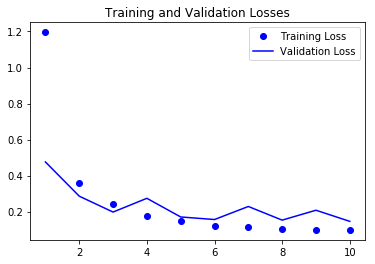

In [22]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

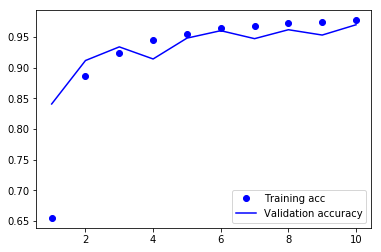

In [23]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Validate against each of the test generators

In [52]:
save_generator_classes(train_generator)

saving ../data/models/asl_alphabet_class_names/2019-05-25__21:33:02.665517-data.json


In [45]:
for generator, _dir in zip(test_generators, LOCAL_TEST_DIRS):
    epoch_steps = steps_per_epoch_test
    if epoch_steps == 0:
        epoch_steps = None
    try:
        test_loss, test_acc = model.evaluate_generator(generator, steps=epoch_steps)
        print('{}: {}'.format(_dir, test_acc))
    except:
        print('cannot run generator {}'.format(generator))

cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a24969080>
cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a24a3e630>
cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a2494e908>
cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a24a3e470>
cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a24969f60>
cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a24a3e710>
cannot run generator <keras_preprocessing.image.DirectoryIterator object at 0x1a24969320>
